In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.ticker import FuncFormatter

%matplotlib inline

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## 1. Начнём с `train`

In [2]:
dtypes = {
    'row_id': 'int32',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'boolean'
}

train = dd.read_csv('train.csv', dtype=dtypes).compute()

In [3]:
train.shape

(101230332, 10)

Датасет огромный, 101 миллион строк. Но с `dask` мы его открыли

In [4]:
train.head(1)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>


Проверим столбцы и память

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101230332 entries, 0 to 1080610
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int32  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 int8   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), int16(2), int32(2), int64(1), int8(3)
memory usage: 3.5 GB


Не так уж и плохо: 3.5 гига на обработку. Думаю, нам хватит ОЗУ

In [6]:
print(f'У нас всего уникальных юзеров: {train.user_id.nunique()}')

У нас всего уникальных юзеров: 393656


`content_type_id`: 0, если событие было вопросом, заданным пользователю, и 1, если событие означало, что пользователь смотрел лекцию.

In [7]:
train.content_type_id.value_counts()

content_type_id
0    99271300
1     1959032
Name: count, dtype: int64

`Content_id` — это код, который показывает, как пользователь взаимодействовал. В Kaggle нам подсказывают: если это вопрос, то `question_id` связан с колонкой `content_id` в данных, когда контент — это именно вопрос.

In [8]:
print(f'В нашем тренировочном наборе данных {train.content_id.nunique()} уникальных content_id, из которых {train[train.content_type_id == 0].content_id.nunique()} — это вопросы.')

В нашем тренировочном наборе данных 13782 уникальных content_id, из которых 13523 — это вопросы.


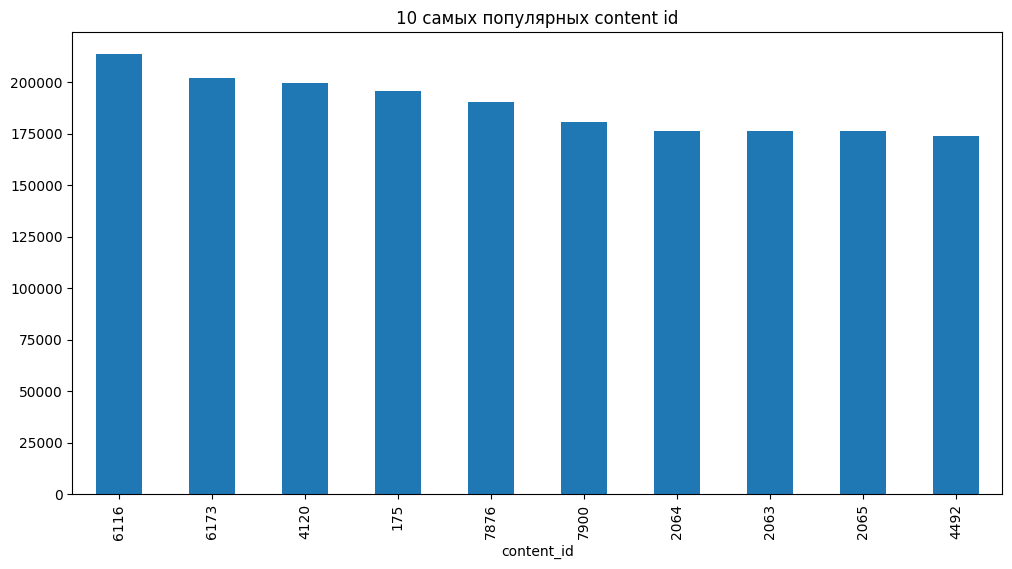

In [11]:
cids = train.content_id.value_counts()[:10]

fig = plt.figure(figsize=(12,6))
ax = cids.plot.bar()
plt.title("10 самых популярных content id")
plt.xticks(rotation=90)
plt.show()

`task_container_id` — это код, который объединяет группу вопросов или лекций. 

Например, если пользователь видит подряд три вопроса, а потом уже объяснения, то все эти три вопроса будут с одним и тем же `task_container_id`.

In [12]:
print(f'Всего у нас {train.task_container_id.nunique()} уникальных батчей вопросов / лекций')

Всего у нас 10000 уникальных батчей вопросов / лекций


`user_answer`: на Kaggle подсказывают, что это вопросы с несколькими вариантами ответа (от 0 до 3). Там же на Kaggle пишут: -1 означает, что ответа нет (потому что взаимодействие было с лекцией, а не с вопросом).

In [13]:
train.user_answer.value_counts()

user_answer
 0    28186489
 1    26990007
 3    26084784
 2    18010020
-1     1959032
Name: count, dtype: int64

`timestamp`: время в миллисекундах между этим взаимодействием пользователя и первым завершённым событием от этого пользователя. 

Видим на графике инсайд: большинство запросов приходят от пользователей, которые совсем недавно появились у нас!

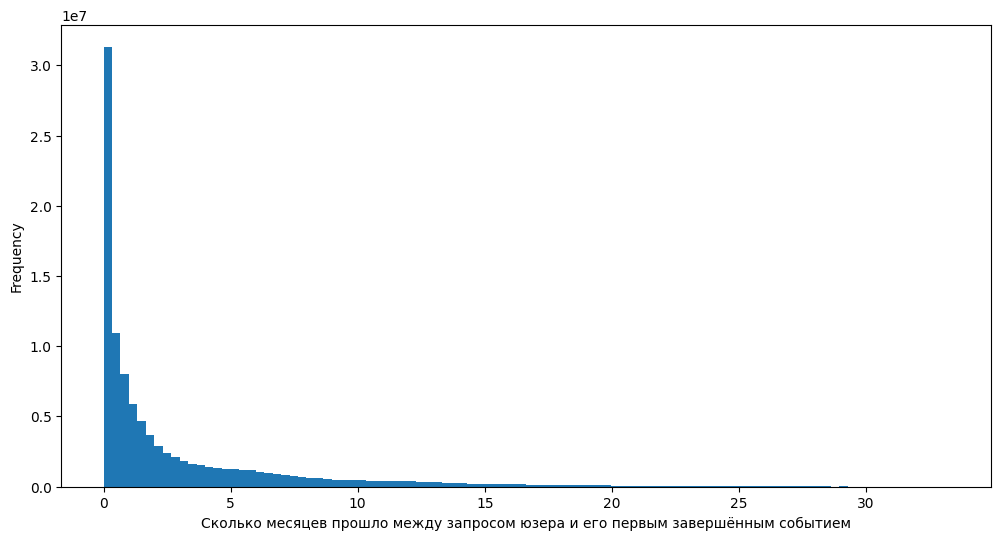

In [15]:
ts = train['timestamp']/(31536000000/12)

fig = plt.figure(figsize=(12,6))
ts.plot.hist(bins=100)
plt.xticks(rotation=0)

plt.xlabel("Сколько месяцев прошло между запросом юзера и его первым завершённым событием")

plt.show()

Answered_correctly - ответил ли юзер правильно. 

Если мы не учитываем взаимодействия с лекциями, где значение -1, примерно 1/3 вопросов судя по графику была отвечена неправильно

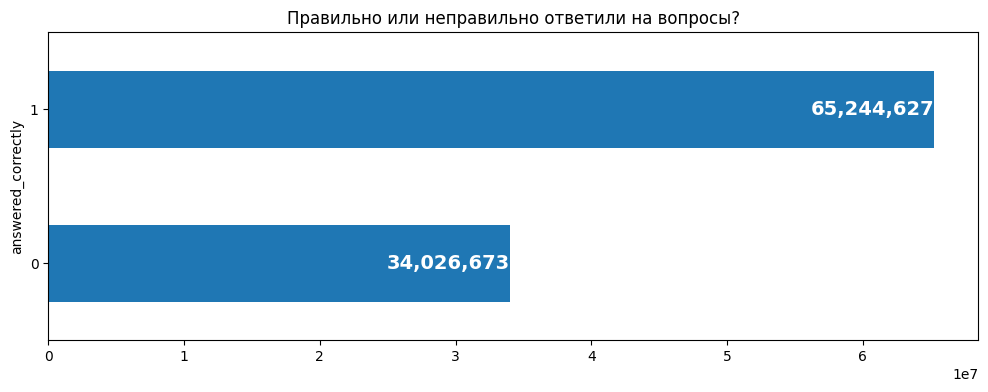

In [16]:
correct = train[train.answered_correctly != -1].answered_correctly.value_counts(ascending=True)

fig = plt.figure(figsize=(12,4))
correct.plot.barh()
for i, v in zip(correct.index, correct.values):
    plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Правильно или неправильно ответили на вопросы?")
plt.xticks(rotation=0)
plt.show()

В целом такой взгляд уже позволяет выделить пару гипотез:

1. Большинство взаимодействий приходят от новеньких. Сразу вопрос к продакт менеджеру: почему люди не задают вопросы дальше? Пользователи остаются, но не участвуют в активности, или они покидают продукт? Как устроен первый контакт на взаимодействии, возможно после него и не хочется больше тыкать в наше приложение?

2. 2/3 правильно отвечает на вопрос. Для обучающего приложения это высокий показатель? Здесь нужна экспертиза в аналитике EdTech. Как нас учили, DS состоит из трёх голов, и третья голова - это экспертиза в области


Под конец построим комплексный график, если выдержит ОЗУ :) 

Проверим, есть ли у наших юзеров корреляция между количеством вопросов и правильным ответом.

Если наши методисты постарались, то чем больше пользователь отвечает на вопросы, тем лучше у него будет результат. Но если мы ничему не учим пользователей, то такого результата не будет.

Конечно, могут быть и другие аргументы: например, более усердные пользователи отвечают на большее количество вопросов, и за счёт усердности у них всегда лучше результаты. Но мы пока не углубляемся настолько глубоко :)

Для начала получим для каждого юзера, который отвечал на вопрос, средний балл и количество ответов:

In [17]:
user_percent = train[train.answered_correctly != -1].groupby('user_id')['answered_correctly'].agg(Mean='mean', Answers='count')

In [19]:
len(user_percent)

393656

Теперь визуализируем их:

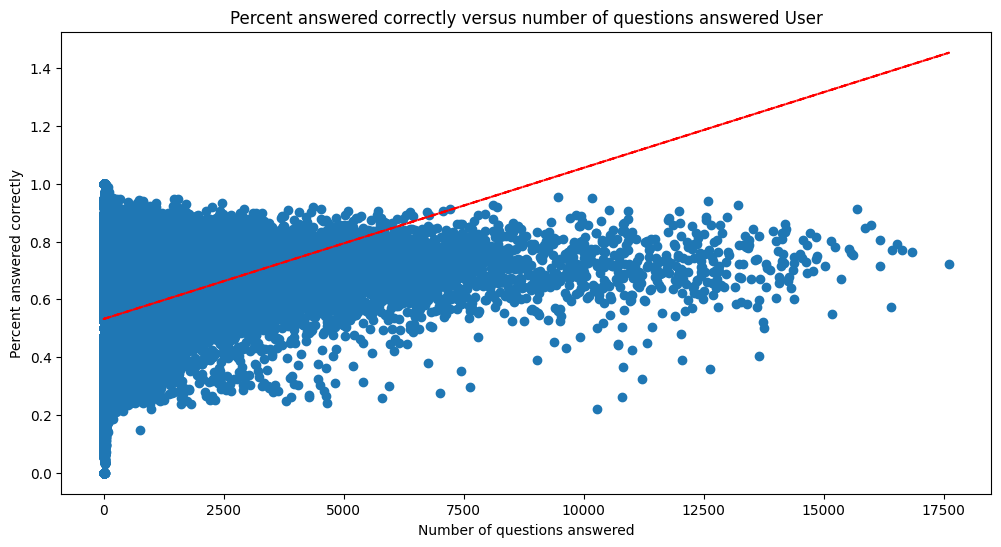

In [20]:
fig = plt.figure(figsize=(12,6))
x = user_percent.Answers
y = user_percent.Mean
plt.scatter(x, y, marker='o')
plt.title("Percent answered correctly versus number of questions answered User")
plt.xticks(rotation=0)
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

Корреляция налицо :) Осталось понять, заслуга ли это наших методистов

## 2. Продолжим с `questions`

In [40]:
questions = pd.read_csv('questions.csv')

In [4]:
print(questions.shape)
questions.head(1)

(13523, 5)


,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38


In [6]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [17]:
questions.describe()

,question_id,bundle_id,correct_answer,part
count,13523.00000,13523.000000,13523.000000,13523.000000
mean,6761.00000,6760.510907,1.455298,4.264956
std,3903.89818,3903.857783,1.149707,1.652553
min,0.00000,0.000000,0.000000,1.000000
25%,3380.50000,3379.500000,0.000000,3.000000
50%,6761.00000,6761.000000,1.000000,5.000000
75%,10141.50000,10140.000000,3.000000,5.000000
max,13522.00000,13522.000000,3.000000,7.000000


`questions` гораздо приятнее для ОЗУ :)

Проверим, где у нас затесались `NaN`:

In [42]:
questions[questions.question_id.isna()]

,question_id,bundle_id,correct_answer,part,tags


In [43]:
questions[questions.bundle_id.isnull()]

,question_id,bundle_id,correct_answer,part,tags


In [44]:
questions[questions.correct_answer.isnull()]

,question_id,bundle_id,correct_answer,part,tags


In [45]:
questions[questions.part.isnull()]

,question_id,bundle_id,correct_answer,part,tags


In [46]:
questions[questions.tags.isna()]

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


Я сразу обращаю ванимание на `tags`, выглядит интересно.

`tags`: один или несколько детализированных кодов тегов для вопроса. Значение этих тегов не будет предоставлено, но этих кодов достаточно для того, чтобы сгруппировать вопросы вместе.

In [47]:
questions[questions.tags.isna()]

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


Только один вопросик без тэга

In [14]:
questions['tags'] = questions['tags'].astype(str)

tags = [x.split() for x in questions[questions.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
print(f'Всего у нас уникальных тэгов: {len(tags)}')

Всего у нас уникальных тэгов: 188


Тут сам файл кажется попроще, поэтому мы можем провести разбор каждого столбца

In [19]:
def get_vc(col):
    return col.value_counts()
    
get_vc(questions.question_id)

question_id
13522    1
0        1
1        1
13506    1
13505    1
        ..
7        1
6        1
5        1
4        1
3        1
Name: count, Length: 13523, dtype: int64

In [20]:
get_vc(questions.correct_answer)

correct_answer
0    3716
3    3544
1    3478
2    2785
Name: count, dtype: int64

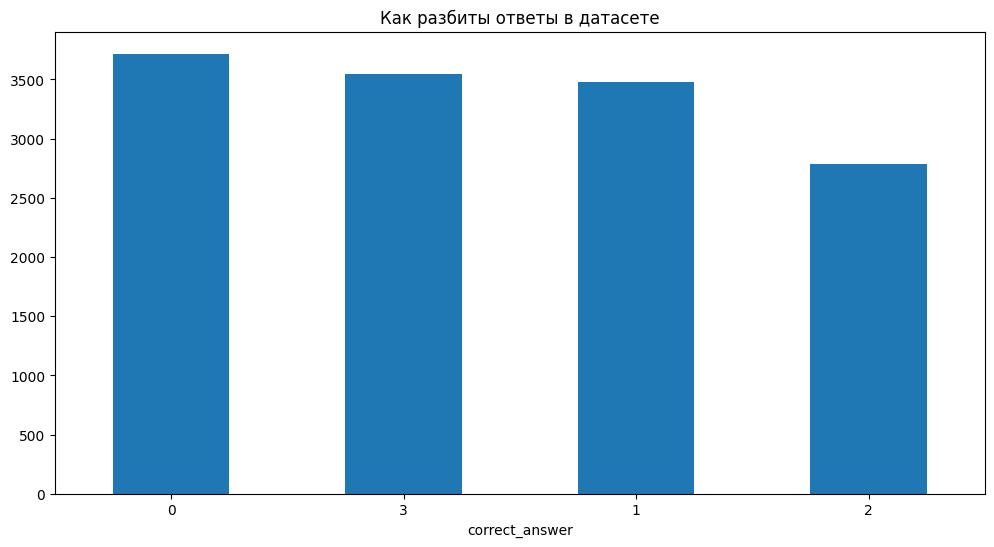

In [25]:
fig = plt.figure(figsize=(12,6))
ax = questions.correct_answer.value_counts().plot.bar()
plt.title("Как разбиты ответы в датасете")
plt.xticks(rotation=360)
plt.show()

Видно, что ответы разбиты почти равномерно

In [26]:
get_vc(questions.part)

part
5    5511
2    1647
3    1562
4    1439
6    1212
7    1160
1     992
Name: count, dtype: int64

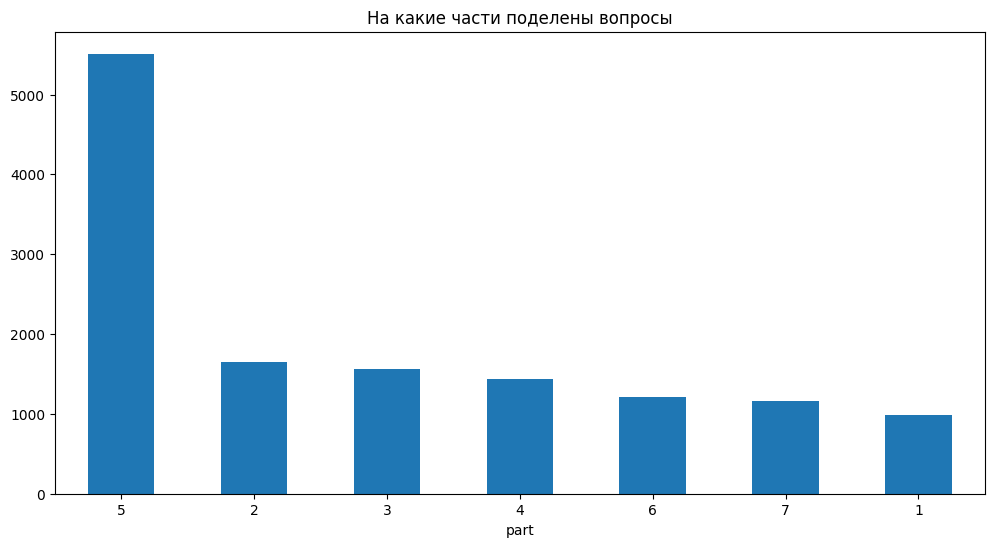

In [28]:
fig = plt.figure(figsize=(12,6))
ax = questions.part.value_counts().plot.bar()
plt.title("На какие части поделены вопросы")
plt.xticks(rotation=360)
plt.show()

А в частях мы видим преобладание пятой части над всеми. Интересно, почему так

In [50]:
del questions

## 3. Заканчиваем с `lectures`

In [48]:
lectures = pd.read_csv('lectures.csv')

print(lectures.shape)
lectures.head(1)

In [51]:
lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [62]:
assert len(lectures) == len(set(lectures.lecture_id))

`id` лекций не повторяется, что хорошо)

Датасет совсем небольшой, приятно

In [53]:
lectures.describe()

,lecture_id,tag,part
count,418.000000,418.000000,418.000000
mean,16983.401914,94.480861,4.267943
std,9426.164660,53.586487,1.872424
min,89.000000,0.000000,1.000000
25%,9026.250000,50.250000,2.000000
50%,17161.500000,94.500000,5.000000
75%,24906.250000,140.000000,6.000000
max,32736.000000,187.000000,7.000000


Всё выглядит логично

Проверим `NaN` в наших данных, их не должно быть:

In [58]:
lectures.isna().any()

lecture_id    False
tag           False
part          False
type_of       False
dtype: bool

Их нет :) Очень удобно

Посмотрим на типы лекций: 

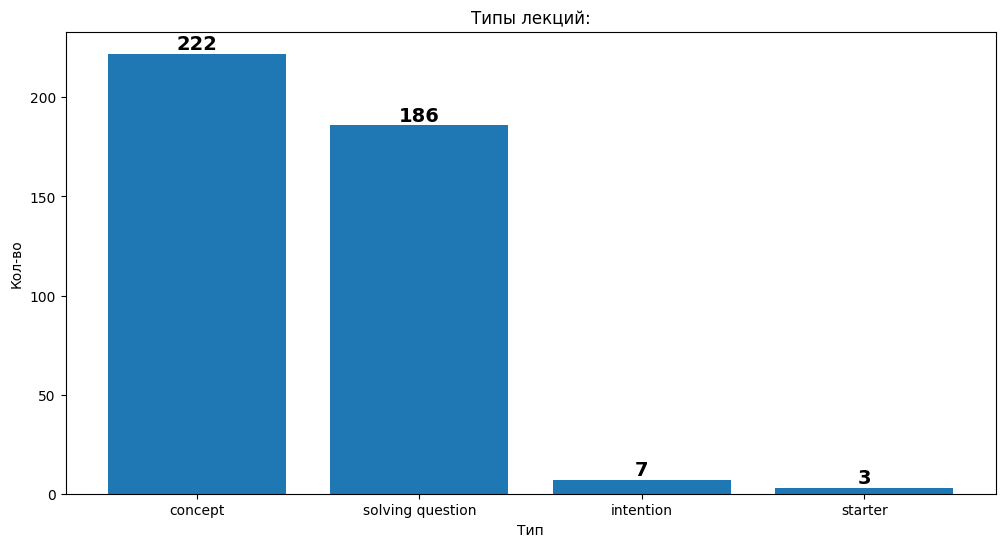

In [55]:
lect_type_of = lectures.type_of.value_counts()

fig = plt.figure(figsize=(12,6))
plt.bar(lect_type_of.index, lect_type_of.values)
for i, v in zip(lect_type_of.index, lect_type_of.values):
    plt.text(i, v, v, color='black', fontweight='bold', fontsize=14, va='bottom', ha='center')
plt.title("Типы лекций:")
plt.xlabel("Тип")
plt.ylabel("Кол-во")
plt.show()

Судя по всему, неравенство очень жёсткое. Первых двух в десятки раз больше

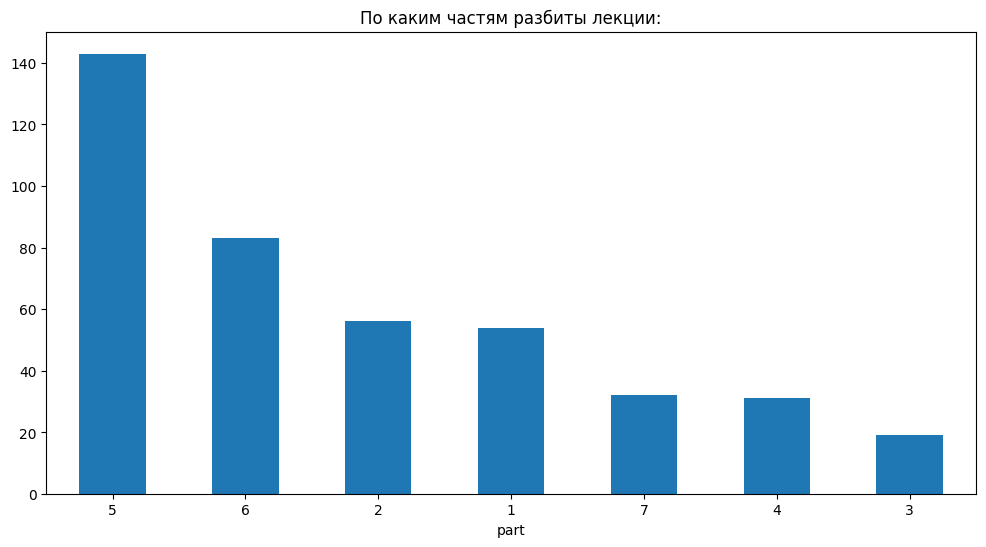

In [60]:
fig = plt.figure(figsize=(12,6))
ax = lectures.part.value_counts().plot.bar()
plt.title("По каким частям разбиты лекции:")
plt.xticks(rotation=360)
plt.show()

Мы опять видим преобладание пятой части! Как и в вопросах

Несмотря на то, что данные не такие интересные, мы всё равно нашли вопрос для наших методистов / продакт менеджеров: 

 - почему `#5` тема настолько лучше раскрыта чем все остальные?
 - не следует ли распределить материал более равномерно, например к теме 3 и 4?

---------------------------------------

Вот такой EDA. Для меня было настоящим вызовом прогрузить датасет `train`, и я открыл для себя `dask.dataframe`. Теперь обязательно буду пользоваться такой палочкой-выручалочкой :)